# Homework for week06

> In this homework, we will use the California Housing Prices from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

> The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).

## Import Packages

In [1]:
%matplotlib inline

from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.tree import export_text

## Preparing the dataset 

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.
But in contrast to homework #2 we are going to use all columns of the dataset.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Preparation:

* Fill missing values with zeros.
* Apply the log tranform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [2]:
data = pd.read_csv('../data/housing.csv')
print(f'{data.shape =}')

data.shape =(20640, 10)


In [3]:
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

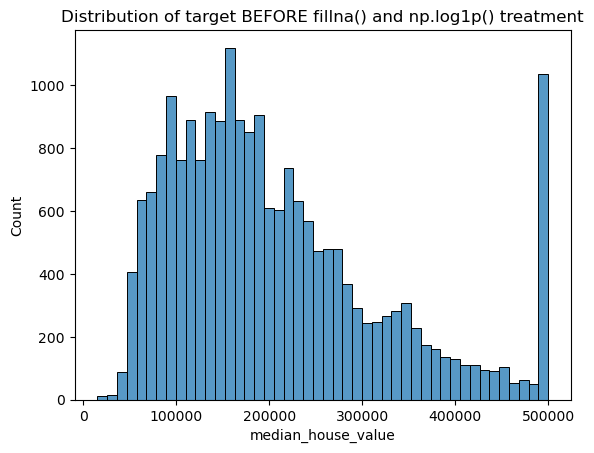

In [4]:
sns.histplot(data.median_house_value)
plt.title('Distribution of target BEFORE fillna() and np.log1p() treatment')
plt.show()

In [5]:
# make a copy to revert to
data_copy = data.copy()
# keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`
data = data.query("ocean_proximity == '<1H OCEAN' or ocean_proximity == 'INLAND'")
# Fill missing values with zeros
data = data.fillna(0)
# Apply the log tranform to `median_house_value`.
data['median_house_value'] = np.log1p(data.median_house_value.values)
print(data['ocean_proximity'].value_counts())
print()
print(f'{data.shape = }')
print()
print(f'{data.columns = }')

ocean_proximity
<1H OCEAN    9136
INLAND       6551
Name: count, dtype: int64

data.shape = (15687, 10)

data.columns = Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')


In [6]:
# confirm no more null values
data.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [7]:
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [8]:
df_full_train.head().T

,13673,6611,2649,6789,3826
longitude,-117.25,-118.11,-124.1,-118.16,-118.45
latitude,34.04,34.18,40.5,34.09,34.2
housing_median_age,18.0,52.0,42.0,52.0,18.0
total_rooms,5761.0,3571.0,2380.0,1722.0,2729.0
total_bedrooms,1063.0,510.0,553.0,448.0,800.0
population,2763.0,1434.0,1300.0,1122.0,2099.0
households,1058.0,490.0,504.0,425.0,742.0
median_income,4.4472,5.9009,1.7574,3.1204,2.5842
median_house_value,11.989787,12.837347,10.959558,12.319406,12.349311
ocean_proximity,INLAND,INLAND,<1H OCEAN,<1H OCEAN,<1H OCEAN


In [9]:
df_full_train.describe().T.round()

,count,mean,std,min,25%,50%,75%,max
longitude,12549.0,-119.0,2.0,-124.0,-121.0,-118.0,-118.0,-114.0
latitude,12549.0,35.0,2.0,33.0,34.0,34.0,37.0,42.0
housing_median_age,12549.0,27.0,12.0,1.0,17.0,27.0,36.0,52.0
total_rooms,12549.0,2650.0,2207.0,6.0,1440.0,2110.0,3167.0,39320.0
total_bedrooms,12549.0,533.0,429.0,0.0,290.0,428.0,641.0,6445.0
population,12549.0,1461.0,1173.0,3.0,800.0,1193.0,1773.0,35682.0
households,12549.0,499.0,385.0,2.0,277.0,405.0,602.0,6082.0
median_income,12549.0,4.0,2.0,0.0,3.0,3.0,5.0,15.0
median_house_value,12549.0,12.0,1.0,10.0,12.0,12.0,12.0,13.0


<Axes: >

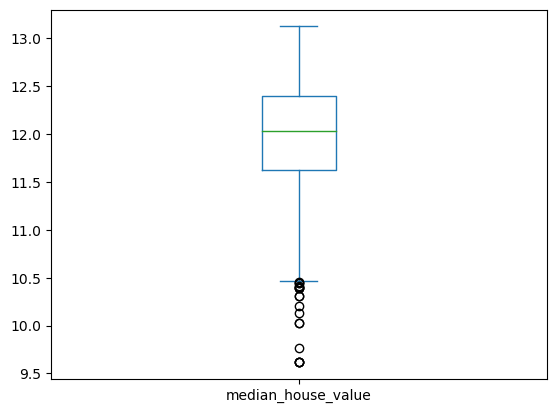

In [10]:
df_full_train['median_house_value'].plot.box()

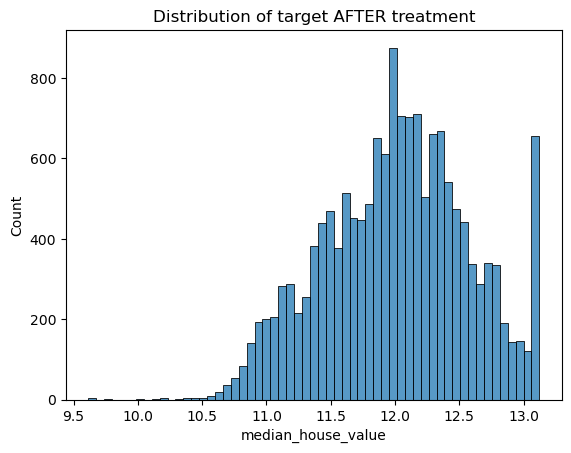

In [11]:
sns.histplot(data.median_house_value)
plt.title('Distribution of target AFTER treatment')
plt.show()

In [12]:
df_full_train['median_house_value'].describe(percentiles=[.05, .25, .50, .75, .95])

count    12549.000000
mean        12.011774
std          0.565790
min          9.615805
5%          11.036517
25%         11.619095
50%         12.028745
75%         12.393386
95%         13.000740
max         13.122367
Name: median_house_value, dtype: float64

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
print(len(df_train), len(df_val), len(df_test))

9411 3138 3138


In [14]:
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values
print(len(y_train), len(y_val), len(y_test))

9411 3138 3138


In [15]:
# remove target from df
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [16]:
print((df_train.shape), (df_val.shape), (df_test.shape))

(9411, 9) (3138, 9) (3138, 9)


### df_train -> X_train

In [17]:
dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(dicts)

### df_val -> X_val

In [18]:
dicts = df_val.to_dict(orient='records')
dv = DictVectorizer(sparse=True)
X_val = dv.fit_transform(dicts)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity`
* `total_rooms`
* `latitude`
* `population`

### DecisionTreeRegressor

In [19]:
dt_regr = DecisionTreeRegressor(max_depth=1)
dt_regr.fit(X_train, y_train)
y_pred = dt_regr.predict(X_val)

print(export_text(dt_regr, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



Q: Which feature is used for splitting the data?

A: `ocean_proximity`

### qn1 ans: `ocean_proximity`



## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)

### RandomForestRegressor

add `n_estimators` to train_rf(df, y, n_estimators)

In [20]:
rf_regr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf_regr.fit(X_train, y_train)
y_pred = rf_regr.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f'RandomForestRegressor RMSE: {rmse.round(3)}')

RandomForestRegressor RMSE: 0.245


Q: What's the RMSE of this model on validation?

### qn2 ans: `0.245`

A: `0.245`

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.

In [21]:
rmse = {}

for n in tqdm(range(10, 201, 10), desc='Looping n_estimators'):
    rf_regr = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf_regr.fit(X_train, y_train)
    y_pred = rf_regr.predict(X_val)

    rmse[str(n)] = mean_squared_error(y_val, y_pred, squared=False).round(3)

Looping n_estimators:   0%|          | 0/20 [00:00<?, ?it/s]

In [22]:
rmse

{'10': 0.245,
 '20': 0.239,
 '30': 0.237,
 '40': 0.236,
 '50': 0.235,
 '60': 0.235,
 '70': 0.234,
 '80': 0.235,
 '90': 0.235,
 '100': 0.234,
 '110': 0.234,
 '120': 0.234,
 '130': 0.234,
 '140': 0.234,
 '150': 0.234,
 '160': 0.233,
 '170': 0.233,
 '180': 0.234,
 '190': 0.234,
 '200': 0.234}

Q: After which value of `n_estimators` does RMSE stop improving?

- 10
- 25
- 50
- 160

### qn3 ans: `160`

A: `160`

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [23]:
from pprint import pprint

rmse_scores = {}

for m in tqdm([10, 15, 20, 25], desc='Looping max_depth'):
    rmse_dict = {}
    
    for n in tqdm(range(10, 201, 10), desc='Looping n_estimators'):
        print(f'Training with params max_depth = {m}\tn_estimators = {n}')
        rf_regr = RandomForestRegressor(n_estimators=n, max_depth=m, random_state=1, n_jobs=-1)
        rf_regr.fit(X_train, y_train)
        y_pred = rf_regr.predict(X_val)

        rmse_dict[str(n)] = mean_squared_error(y_val, y_pred, squared=False).round(3)

    pprint(rmse_dict, indent=5, sort_dicts=False)
    rmse_scores[str(m)] = {
        'min' : np.min(list(rmse_dict.values())),
        'mean' : np.mean(list(rmse_dict.values())),
        'max' : np.max(list(rmse_dict.values()))
    }


Looping max_depth:   0%|          | 0/4 [00:00<?, ?it/s]

Looping n_estimators:   0%|          | 0/20 [00:00<?, ?it/s]

Training with params max_depth = 10	n_estimators = 10
Training with params max_depth = 10	n_estimators = 20
Training with params max_depth = 10	n_estimators = 30
Training with params max_depth = 10	n_estimators = 40
Training with params max_depth = 10	n_estimators = 50
Training with params max_depth = 10	n_estimators = 60
Training with params max_depth = 10	n_estimators = 70
Training with params max_depth = 10	n_estimators = 80
Training with params max_depth = 10	n_estimators = 90
Training with params max_depth = 10	n_estimators = 100
Training with params max_depth = 10	n_estimators = 110
Training with params max_depth = 10	n_estimators = 120
Training with params max_depth = 10	n_estimators = 130
Training with params max_depth = 10	n_estimators = 140
Training with params max_depth = 10	n_estimators = 150
Training with params max_depth = 10	n_estimators = 160
Training with params max_depth = 10	n_estimators = 170
Training with params max_depth = 10	n_estimators = 180
Training with param

Looping n_estimators:   0%|          | 0/20 [00:00<?, ?it/s]

Training with params max_depth = 15	n_estimators = 10
Training with params max_depth = 15	n_estimators = 20
Training with params max_depth = 15	n_estimators = 30
Training with params max_depth = 15	n_estimators = 40
Training with params max_depth = 15	n_estimators = 50
Training with params max_depth = 15	n_estimators = 60
Training with params max_depth = 15	n_estimators = 70
Training with params max_depth = 15	n_estimators = 80
Training with params max_depth = 15	n_estimators = 90
Training with params max_depth = 15	n_estimators = 100
Training with params max_depth = 15	n_estimators = 110
Training with params max_depth = 15	n_estimators = 120
Training with params max_depth = 15	n_estimators = 130
Training with params max_depth = 15	n_estimators = 140
Training with params max_depth = 15	n_estimators = 150
Training with params max_depth = 15	n_estimators = 160
Training with params max_depth = 15	n_estimators = 170
Training with params max_depth = 15	n_estimators = 180
Training with param

Looping n_estimators:   0%|          | 0/20 [00:00<?, ?it/s]

Training with params max_depth = 20	n_estimators = 10
Training with params max_depth = 20	n_estimators = 20
Training with params max_depth = 20	n_estimators = 30
Training with params max_depth = 20	n_estimators = 40
Training with params max_depth = 20	n_estimators = 50
Training with params max_depth = 20	n_estimators = 60
Training with params max_depth = 20	n_estimators = 70
Training with params max_depth = 20	n_estimators = 80
Training with params max_depth = 20	n_estimators = 90
Training with params max_depth = 20	n_estimators = 100
Training with params max_depth = 20	n_estimators = 110
Training with params max_depth = 20	n_estimators = 120
Training with params max_depth = 20	n_estimators = 130
Training with params max_depth = 20	n_estimators = 140
Training with params max_depth = 20	n_estimators = 150
Training with params max_depth = 20	n_estimators = 160
Training with params max_depth = 20	n_estimators = 170
Training with params max_depth = 20	n_estimators = 180
Training with param

Looping n_estimators:   0%|          | 0/20 [00:00<?, ?it/s]

Training with params max_depth = 25	n_estimators = 10
Training with params max_depth = 25	n_estimators = 20
Training with params max_depth = 25	n_estimators = 30
Training with params max_depth = 25	n_estimators = 40
Training with params max_depth = 25	n_estimators = 50
Training with params max_depth = 25	n_estimators = 60
Training with params max_depth = 25	n_estimators = 70
Training with params max_depth = 25	n_estimators = 80
Training with params max_depth = 25	n_estimators = 90
Training with params max_depth = 25	n_estimators = 100
Training with params max_depth = 25	n_estimators = 110
Training with params max_depth = 25	n_estimators = 120
Training with params max_depth = 25	n_estimators = 130
Training with params max_depth = 25	n_estimators = 140
Training with params max_depth = 25	n_estimators = 150
Training with params max_depth = 25	n_estimators = 160
Training with params max_depth = 25	n_estimators = 170
Training with params max_depth = 25	n_estimators = 180
Training with param

something wrong here, they are all the same:
```
rmse_scores[str(m)] = {
    'max' : rmse_dict[str(n)].max().round(5),
    'mean' : rmse_dict[str(n)].mean().round(5),
    'min' : rmse_dict[str(n)].min().round(5)
    }
```
```
{'10': {'max': 0.24477, 'mean': 0.24477, 'min': 0.24477},
 '15': {'max': 0.2346, 'mean': 0.2346, 'min': 0.2346},
 '20': {'max': 0.23392, 'mean': 0.23392, 'min': 0.23392},
 '25': {'max': 0.23374, 'mean': 0.23374, 'min': 0.23374}}
```

At what point do I record the min/max values?

correction: `max(foo.values())` as example

```
    rmse_scores[str(m)] = {
        'min' : np.min(list(rmse_dict.values())),
        'mean' : np.mean(list(rmse_dict.values())),
        'max' : np.max(list(rmse_dict.values()))
    }
```

In [24]:
pprint(rmse_scores)

{'10': {'max': 0.251, 'mean': 0.24559999999999998, 'min': 0.244},
 '15': {'max': 0.246, 'mean': 0.23610000000000006, 'min': 0.234},
 '20': {'max': 0.245, 'mean': 0.23529999999999998, 'min': 0.234},
 '25': {'max': 0.244, 'mean': 0.23475000000000001, 'min': 0.233}}


Q: What's the best `max_depth`:

* 10
* 15
* 20
* 25

### qn4 ans: 25

A: `25`

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [25]:
rf_regr = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf_regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

For example, if importances is an array of feature importances, then importances.argsort() would return an array of indices such that importances[indices[0]] is the importance of the least important feature, and importances[indices[-1]] is the importance of the most important feature.

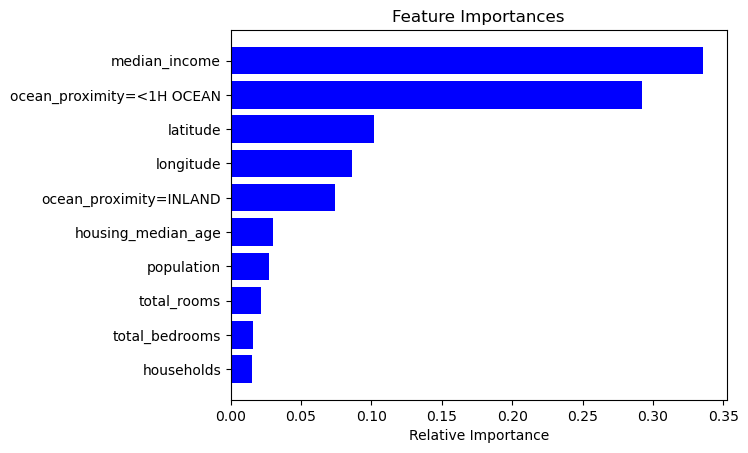

In [26]:
features = dv.feature_names_
importances = rf_regr.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Q: What's the most important feature (among these 4)? 

* `total_rooms`
* `median_income`
* `total_bedrooms`
* `longitude`

### qn5 ans: `median_income`

A: `median_income`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

In [27]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [28]:
features = dv.feature_names_
features= [sym.replace("=<", "_lt_").replace("=","_") for sym in features]
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity_lt_1H OCEAN',
 'ocean_proximity_INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [29]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [30]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

scores = {}

In [38]:
%%capture output

eta = 0.1
xgb_params = {
    'eta': eta, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
    "device": "cuda",
}

model = xgb.train(
    xgb_params, 
    dtrain, 
    num_boost_round=100,
    evals=watchlist,
    verbose_eval=5
)

In [39]:
s = output.stdout

In [40]:
print(s[:100])

[0]	train-rmse:0.52432	val-rmse:0.52014
[5]	train-rmse:0.37798	val-rmse:0.38110
[10]	train-rmse:0.30


In [41]:
y_pred = model.predict(dval)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f'eta = {eta}\trmse = {rmse}')

eta = 0.1	rmse = 0.2336004709022021


In [42]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

In [43]:
scores.keys()

dict_keys(['eta=0.3', 'eta=0.1'])

In [44]:
print(f"{scores['eta=0.3']['val_rmse'].min() = }")
print(f"{scores['eta=0.1']['val_rmse'].min() = }")

scores['eta=0.3']['val_rmse'].min() = 0.22961
scores['eta=0.1']['val_rmse'].min() = 0.2336


In [ ]:
# print(np.min(scores.items()))

In [45]:
df_score = parse_xgb_output(output)

Q: Which eta leads to the best RMSE score on the validation dataset?

* 0.3 == rmse = 0.22961
* 0.1 == rmse = 0.2336
* Both give equal value

### qn6 ans: `0.3`

A: `0.3`

### Plot for tuning eta values

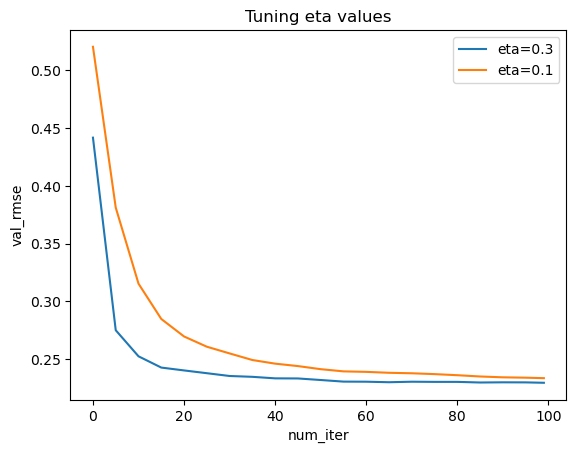

In [46]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)

plt.title(f'Tuning eta values')
plt.xlabel(f'num_iter')
plt.ylabel(f'val_rmse')
# plt.ylim(0.77, 0.84)
plt.legend()
plt.show()